In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
set_config(transform_output = "pandas")

# Import model specific code. Explicitly import custom preprocessing functions (i.e., extract_day_of_year)
from Ensemble_Functions import En_test_train_validation_split, load_constituent_models, load_constituent_pipelines, ModelPredictor
from ANN.ANN_functions import ANN_predict_proba
from RF.RF_functions import RF_predict_proba
from SVM.SVM_functions import SVM_predict
from XGBoost.XGB_functions import XGB_predict_proba

In [2]:
## Load models ##
def extract_day_of_year(X): # Define a commonly used function in preprocessing
    day_of_year = X['date'].dt.dayofyear.to_frame(name='day_of_the_year')
    return day_of_year

models = load_constituent_models("ANN/ANN.h5","RF/RF.joblib","SVM/SVM.joblib","XGBoost/final_XGBoost.json")
ANN_model = models["ANN/ANN.h5"]
RF_model = models["RF/RF.joblib"]
SVM_model = models["SVM/SVM.joblib"]
XGB_model = models["XGBoost/final_XGBoost.json"]


pipelines = load_constituent_pipelines("ANN/ANN_pipeline.joblib","RF/RF_pipeline.joblib","SVM/SVM_pipeline.joblib","XGBoost/XGB_pipeline.joblib")
ANN_pipeline = pipelines["ANN/ANN_pipeline.joblib"]
RF_pipeline = pipelines["RF/RF_pipeline.joblib"]
SVM_pipeline = pipelines["SVM/SVM_pipeline.joblib"]
XGB_pipeline = pipelines["XGBoost/XGB_pipeline.joblib"]

# Freeze the ANN model
for layer in ANN_model.layers:
    layer.trainable = False

In [4]:
# Functions to simplify testing different models

def load_downsampled_df():
    main_df = pd.read_csv("downsampled_df.csv",index_col=0)
    main_df['date'] = pd.to_datetime(main_df['date'])
    return main_df

def load_full_df():
    main_df = pd.read_csv("processed_wildfire_ERA5_FWI.csv",index_col=0)
    main_df['date'] = pd.to_datetime(main_df['date'])
    main_df.rename(columns={'latitude_ERA5': 'latitude', 'longitude_ERA5': 'longitude'},inplace=True)
    unnamed_cols = [col for col in main_df.columns if col.startswith('Unnamed:')]
    main_df.drop(columns=unnamed_cols, inplace=True)
    main_df['type_of_high_vegetation'] = main_df['type_of_high_vegetation'].astype(int)
    main_df['type_of_low_vegetation'] = main_df['type_of_low_vegetation'].astype(int)
    return main_df

In [14]:
## Load and split data ##

# Load wildfire dataframe and perform simple preprocessing
#main_df = load_downsampled_df()
main_df = load_full_df()

# Create the validation dataframe out of data after 2019
validation_df = main_df[main_df['date'] > pd.Timestamp('2019-01-01')]
test_train_df = main_df[main_df['date'] < pd.Timestamp('2019-01-01')]

# Get the splits
X_train, X_test, X_validation, y_train, y_test, y_validation = En_test_train_validation_split(validation_df, test_train_df)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)

In [6]:
## Create model predictors ##

ann_predictor = ModelPredictor(ANN_model, ANN_pipeline, ANN_predict_proba, 'ANN')
rf_predictor = ModelPredictor(RF_model, RF_pipeline, RF_predict_proba, 'RF')
svm_predictor = ModelPredictor(SVM_model,SVM_pipeline,SVM_predict, 'SVM')
xgb_predictor = ModelPredictor(XGB_model,XGB_pipeline,XGB_predict_proba,'XGB')

In [7]:
## Create the predictions features ##
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC

ann = FunctionTransformer(ann_predictor.predict, validate=False)
rf = FunctionTransformer(rf_predictor.predict, validate=False)
svm = FunctionTransformer(svm_predictor.predict, validate=False)
xgb = FunctionTransformer(xgb_predictor.predict, validate=False)

Participant_preditcions = FeatureUnion([
    ('ann', ann),
    ('rf', rf),
    ('svm',svm),
    ('xgb',xgb)
])

# Create prediction feature space
create_predictions_pipeline = Pipeline([
    ('feature_union', Participant_preditcions),
])

In [8]:
X_train_predictions = create_predictions_pipeline.transform(X_train.reset_index(drop=True))
#X_train_predictions.to_csv('X_train_ANN-RT-SVM-XGB_downsample.csv')
#X_train_predictions = pd.read_csv('X_train_predictions.csv')

2124/2124 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step


In [12]:
## Initial Grid Search ##
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier

# Classifier
stacking_classifier = DecisionTreeClassifier(random_state=61)

# Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Perform grid search
grid_search = GridSearchCV(stacking_classifier, param_grid, cv=stratified_kfold, scoring=f1,n_jobs=4,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#GS1

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
F1 Score: 79.48%


5637/5637 ━━━━━━━━━━━━━━━━━━━━ 3s 505us/step


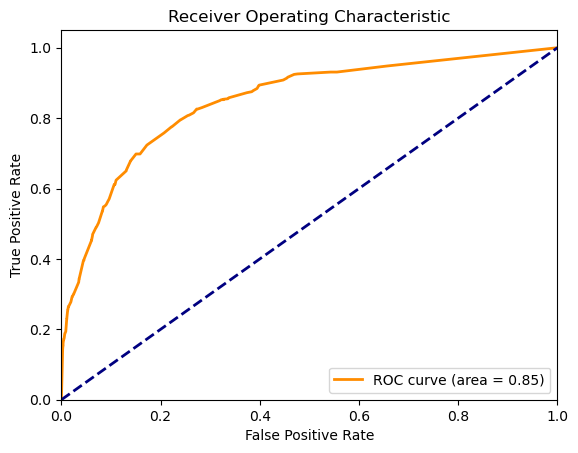

In [15]:
from Visualization_functions import generate_visualizations, plot_roc_curve

X_val_processed = create_predictions_pipeline.transform(X_validation)
y_validation_pred_proba = best_ensemble_pipeline.predict_proba(X_val_processed)
plot_roc_curve(y_validation,y_validation_pred_proba[:,1])

In [18]:
y_validation_pred = (y_validation_pred_proba[:,1] > 0.5).astype(int)
generate_visualizations(X_validation,y_validation_pred,y_validation,main_df,'DTstacking_ANN-RT-SVM-XGB_Visuals')

In [19]:
from sklearn.metrics import accuracy_score, f1_score

# Predict on the validation set

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_validation, y_validation_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_validation, y_validation_pred))

Validation set accuracy: 0.9752343780319452
f1 score:  0.08966782147951906


In [20]:
from joblib import dump

dump(best_ensemble_pipeline,'DT_ANN-RT-SVM-XGB_model.joblib')

['DT_ANN-RT-SVM-XGB_model.joblib']

In [21]:
import numpy as np

np.save('DT_ANN-RT-SVM-XGB_valid_proba.npy',y_validation_pred_proba[:,1])

In [15]:
from joblib  import dump

dump(best_ensemble_pipeline,'SVM_stacking_GS1.joblib')

['SVM_stacking_GS1.joblib']

**Voting on validation set**

In [21]:
X_voting = X_val_processed.copy().astype(int)
X_voting['Most_Occurring'] = X_voting.mode(axis=1)[0]

In [23]:
y_voting_pred = X_voting['Most_Occurring']
accuracy = accuracy_score(y_validation, y_voting_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_validation, y_voting_pred))

Validation set accuracy: 0.9958308153749771
f1 score:  0.0


**Imported Code**

In [26]:
## Final Model from pipeline import ##
import joblib

partial_pipeline = joblib.load('ensemble_partial_pipeline.joblib')
sub_pipeline_steps = partial_pipeline.steps
ensemble_pipeline = Pipeline([('participant_predictions', Participant_preditcions)] + sub_pipeline_steps)

In [ ]:
## Save the parts of the pipeline after participant model predictions ##
import joblib

# Step 1: Create a sub-pipeline starting from the 'day_of_year' step
sub_pipeline = Pipeline([
    ('day_of_year', ensemble_pipeline.named_steps['day_of_year']),
    ('feature_union', ensemble_pipeline.named_steps['feature_union']),
    ('classifier', ensemble_pipeline.named_steps['classifier'])
])

# Step 2: Save the sub-pipeline using joblib
joblib.dump(sub_pipeline, 'ensemble_partial_pipeline.joblib')

**Visualizations**

In [9]:
## Performance on test and validation data ##
#y_test_ensemble_predictions = best_ensemble_pipeline.predict(X_test_predictions)
y_val_pred_proba = ensemble_pipeline.predict_proba(X_validation)

5637/5637 ━━━━━━━━━━━━━━━━━━━━ 3s 499us/step


In [31]:
from Visualization_functions import generate_visualizations

y_val_pred = (y_val_pred_proba[:,1] > 0.5).astype(int)
generate_visualizations(X_val_predictions,y_val_pred,y_validation,main_df,"Ensemble_Visuals")

In [66]:
from sklearn.metrics import accuracy_score, f1_score

# Predict on the validation set
y_validation_pred = (y_val_pred_proba[:,1] > 0.2).astype(int)

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_validation, y_validation_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_validation, y_validation_pred))

5637/5637 ━━━━━━━━━━━━━━━━━━━━ 3s 522us/step
Validation set accuracy: 0.8033220417916406
f1 score:  0.029066425814927334


In [32]:
import numpy as np
np.save('Ensemble_val_proba.np',y_val_pred_proba)

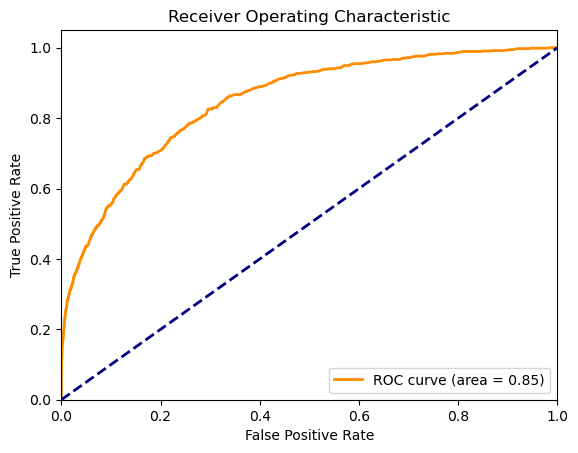

In [12]:
from Visualization_functions import plot_roc_curve

plot_roc_curve(y_validation, y_val_pred_proba[:,1])

In [61]:
import importlib
import Visualization_functions

importlib.reload(Visualization_functions)

<module 'Visualization_functions' from 'c:\\Users\\Chis\\Documents\\Python\\ML\\AI&ML_Course\\Final_Project\\Ensemble_model\\Visualization_functions.py'>

In [69]:
from Visualization_functions import generate_visualizations
y_validation_pred = (y_val_pred_proba[:,1] > 0.5).astype(int)
generate_visualizations(X_validation,y_validation_pred,y_validation,main_df,'Visualization_test')

5637/5637 ━━━━━━━━━━━━━━━━━━━━ 3s 535us/step


**Hyperparameter Tuning**

In [ ]:
create_predictions_pipeline = Pipeline([
    ('feature_union', Participant_preditcions),
])

X_train_predictions = create_predictions_pipeline.transform(X_train.reset_index(drop=True))
X_test_predictions = create_predictions_pipeline.transform(X_test.reset_index(drop=True))
X_validation_predictions = create_predictions_pipeline.transform(X_validation.reset_index(drop=True))
#X_train_predictions.keys()

In [37]:
## Initial Grid Search ##
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'classifier__n_estimators': [75,200,500],  # Number of trees in the forest
    'classifier__max_depth': [8,10,60],
    #'classifier__min_samples_leaf': [2,5,40],
    #'classifier__min_samples_split': [5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'classifier__max_depth': 60, 'classifier__n_estimators': 500}
F1 Score: 80.32%


In [38]:
## Secondary Grid Search ##
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'classifier__n_estimators': [400,500,800],  # Number of trees in the forest
    'classifier__max_depth': [60,80,None],
    'classifier__min_samples_leaf': [2,10,50],
    #'classifier__min_samples_split': [5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Fitting 5 folds for each of 27 candidates, totalling 135 fits
#Best parameters: {'classifier__max_depth': 60, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 800}
#F1 Score: 80.17%

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'classifier__max_depth': 60, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 800}
F1 Score: 80.17%


In [39]:
## Tertiary Grid Search ##
param_grid = {
    'classifier__n_estimators': [700,800,1200],
    'classifier__max_depth': [55,60,65],
    'classifier__min_samples_leaf': [None,2,10],
    #'classifier__min_samples_split': [5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=8,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 1200}
#F1 Score: 80.21%

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._fina

Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 1200}
F1 Score: 80.21%


In [40]:
## 4th Grid Search ##
param_grid = {
    'classifier__n_estimators': [1200],
    'classifier__max_depth': [50,55],
    'classifier__min_samples_leaf': [1,2],
    'classifier__min_samples_split': [2,5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=8,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Fitting 5 folds for each of 12 candidates, totalling 60 fits
#Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1200}
#F1 Score: 80.28%

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1200}
F1 Score: 80.28%


In [44]:
## 5th Grid Search ##
param_grid = {
    'classifier__n_estimators': [1200, 1500],
    'classifier__max_depth': [55,60],
    'classifier__min_samples_leaf': [1,2],
    #'classifier__min_samples_split': [2] #default 2
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Fitting 5 folds for each of 8 candidates, totalling 40 fits
#Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 1500}
#F1 Score: 80.00%

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 1500}
F1 Score: 80.00%


In [46]:
## Performance on test and validation data ##
#y_test_ensemble_predictions = best_ensemble_pipeline.predict(X_test_predictions)
y_validation_ensemble_predictions_proba = best_ensemble_pipeline.predict_proba(X_validation_predictions)


In [53]:
from sklearn.metrics import accuracy_score, f1_score

# Predict on the validation set
y_validation_pred = (best_ensemble_pipeline.predict_proba(X_validation_predictions)[:,1] > 0.2).astype(int)

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_validation, y_validation_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_validation, y_validation_pred))

Validation set accuracy: 0.7634984381972334
f1 score:  0.6156635242929659
